### 测试稀疏矩阵运算 $\Leftarrow$ `SparseTensor, spspmm`

In [1]:
import torch
import numpy as np
from torch_sparse import SparseTensor, spspmm
import pickle


/home/lihao/hdd/anaconda3/envs/sognn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
edge_index = pickle.load(open('./edge_index.pkl', 'rb'))
nodes = torch.max(edge_index).item() + 1
sp1 = SparseTensor.from_edge_index(edge_index, sparse_sizes=(nodes, nodes))
print(sp1)
vl1 = torch.ones((edge_index.shape[1])).cuda()
np.random.seed(1)
eix = edge_index.clone()
val = vl1.clone()
for _ in range(4):
    eix, val = spspmm(eix, val, edge_index, vl1, nodes, nodes, nodes)
print(val.dtype)

SparseTensor(row=tensor([    0,     0,     0,  ..., 19714, 19715, 19716], device='cuda:0'),
             col=tensor([ 1378,  1544,  6092,  ..., 12278,  4284, 16030], device='cuda:0'),
             size=(19717, 19717), nnz=88649, density=0.02%)
torch.float32


In [3]:

ei = eix[0]
ei_ = torch.cat([ei[0:1], ei[:-1]])

cutpoints = torch.nonzero(ei - ei_).squeeze().tolist()
cutpoints = [0] + cutpoints + [ei.shape[0]]
len(cutpoints)

19718

In [4]:
adj_raw = [(eix[:, start:end], val[start:end]) for start, end in zip(cutpoints[:-1], cutpoints[1:])]
a = 0
for (data, val) in adj_raw:
    a = max(len(val), a)
a

17951

In [75]:
mean_value = [torch.mean(value) / 1. for data, value in adj_raw]
adj_selected_raw = [data[:, value<mean] for (data, value), mean in zip(adj_raw, mean_value)]
adj_selected = torch.cat(adj_selected_raw, dim=-1)

In [77]:
SparseTensor.from_edge_index(adj_selected, sparse_sizes=(nodes, nodes))

SparseTensor(row=tensor([0, 0]),
             col=tensor([1, 2]),
             size=(4, 4), nnz=2, density=12.50%)

In [12]:
a = torch.tensor([1, 3, 14, 2, 2, 15, 444, 31, 2])
b = torch.tensor([[1, 3, 14, 2, 2, 15, 444, 31, 2],[1, 3, 14, 2, 2, 15, 444, 31, 2]])
_, index = torch.topk(a, 5, largest=False)
print(index)
index = torch.sort(index).values
b[:,index]

tensor([0, 4, 8, 3, 1])


tensor([[1, 3, 2, 2, 2],
        [1, 3, 2, 2, 2]])

In [ ]:
import torch
edge_index = torch.tensor([[0, 0, 1, 2, 3, 4],[1, 2, 4, 3, 0, 0]])
value = torch.tensor([0, 0, 1, 2, 3, 4])
ei = edge_index[0]
ei_ = torch.cat([ei[0:1], ei[:-1]])

cutpoints = torch.nonzero(ei - ei_).squeeze().tolist()
cutpoints = [0] + cutpoints + [ei.shape[0]]

# 2. 切分spt
adj_raw = [(edge_index[:, start:end], value[start:end]) 
            for start, end in zip(cutpoints[:-1], cutpoints[1:])]
for (data, value) in adj_raw:
    print(len(data[0]), len(value))
    print(data, value)

### 测试plot_influence $\Leftarrow$ `torch.autograd`

In [3]:
import torch
from torch_sparse import SparseTensor
from models.sognn import NodeLevelSOGNN
from models.sognn_layer import SOGNNConv
from models.gcn import NodeLevelGCN

from models.utils import get_jacobian
from torch_geometric.data import Data

/home/lihao/hdd/anaconda3/envs/sognn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
edge_index = torch.LongTensor([
    [0, 1, 2, 3, 3, 3, 3, 4, 5, 5, 5, 5, 6, 7, 7, 8, 8, 9],
    [3, 3, 3, 0, 1, 2, 5, 5, 3, 4, 6, 7, 5, 5, 8, 7, 9, 8]
])
print(len(str(edge_index[0][1].item())))
# value = torch.ones((edge_index.shape[1]))
# x = torch.rand((10, 20), requires_grad=True)
# data = Data(x, edge_index, value)
# # y = x.clone()
# adj_m = SparseTensor.from_edge_index(edge_index,sparse_sizes=(10, 10)).to_dense(dtype=torch.long)
# adj_m_d = torch.matmul(adj_m, adj_m)
# adj_m_d = torch.matmul(adj_m_d, adj_m)
# adj_m_d_s = SparseTensor.from_dense(adj_m_d).cuda()
# SOGNNConv.edge_index_distant = adj_m_d_s
# sognn = NodeLevelSOGNN(20, 3, 10, 0, 0.5, 0.001, 0.01)
# gcn = NodeLevelGCN(20, 3, 10, 0, 0.5, 0.001, 0.01)
# for r in range(8):
#     print(get_jacobian(sognn, data, 0, r))
#     print(get_jacobian(gcn, data, 0, r))


3


In [2]:
a = [1, 3, 4]
print(a.remove(3))

None


### 测试数据集

In [2]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid, WikipediaNetwork, WebKB
from torch_geometric.loader import DataLoader
import torch

In [3]:
cornell = WebKB(root='../data', name='cornell')
data = DataLoader(cornell, 4, shuffle=True)

In [6]:
data.dataset.data.edge_index

tensor([[  0,   0,   1,   2,   2,   6,   6,   8,   8,   8,   8,   8,   9,  10,
          10,  10,  10,  12,  13,  18,  19,  20,  20,  20,  20,  20,  21,  21,
          21,  21,  22,  22,  24,  24,  24,  24,  24,  24,  24,  25,  25,  27,
          27,  27,  28,  28,  29,  31,  33,  35,  41,  41,  42,  43,  48,  48,
          52,  53,  53,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,
          57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  57,  62,  62,
          63,  64,  65,  65,  66,  66,  66,  66,  66,  66,  66,  66,  66,  67,
          67,  67,  67,  67,  67,  67,  67,  69,  70

### Networkx画图

In [6]:
import networkx as nx
import pickle
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

graph = nx.Graph()
graph.add_edges_from([
    (1,2),(2,3),(3,4),(2,6),(3,6),(5,6),(6,7),(7,8)
])


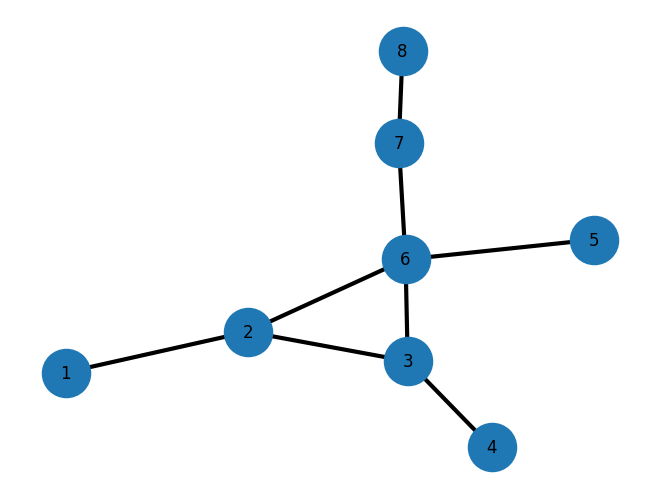

In [16]:
nx.draw(graph, with_labels=True, alpha=1, node_size=1200, width=2.5)

In [19]:
path_lengths = nx.single_source_dijkstra_path_length(G, 0)
r = 8
[node for node, length in path_lengths.items() if length<=5].__len__()

654

### 其他测试

In [6]:
def test(**kwargs):
    for (key, value) in kwargs.items():
        print(f"{key}: {value}")
    print(kwargs['r'])
test(r=3, a=4, b="hahaha")

r: 3
a: 4
b: hahaha
3
